# NLP and LLM-based Analysis of Student Emotion Diaries

## Load packages

In [1]:
# import moduels
import numpy as np
import pandas as pd
import re
import csv
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import json
import hashlib
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from openai import OpenAI
from neo4j_graphrag.llm import OpenAILLM
import neo4j
from neo4j_graphrag.generation.prompts import ERExtractionTemplate
from neo4j_graphrag.experimental.components.kg_writer import Neo4jWriter
from neo4j_graphrag.experimental.components.types import Neo4jGraph
from IPython.display import Image, display

import torch
os.environ["WANDB_DISABLED"] = "true"
from transformers import AutoTokenizer, AutoModelForAudioClassification, TrainingArguments, Trainer, AutoModelForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support


plt.rcParams['font.family'] = 'AppleGothic' 

## Data Preprocessing

### Digitalization - Google AI Studio

### Constructing Dataframe

In [2]:
# Open text data
with open('raw_data.txt', 'r', encoding='utf-8') as f:
    raw_text = f.read()

# Devide text by name
blocks = re.split(r'\n(?=[가-힣]{2,4}\n일기 \d+\n)',raw_text) #re.split(pattern, string)

rows = []
word = []

for block in blocks :
    word.append(str.split(block, '\n'))

# Create Dataframe
raw_data = pd.DataFrame(columns=['Name', 'Number', 'Date', 'Weather', 'Emotion', 'Diary title' ,'Diary'])

# Extract componets from each dairy entry and insert them into dataframe(raw_data)
def extract_value(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):].strip()
    return ''


for row in word:

    name = row[0]
    number = row[1]


    date = ''
    weather = ''
    emotion = ''
    title = ''
    diary_text = ''

    for text in row:
        if text.startswith('날짜:'):
            date = extract_value(text, '날짜:')
        elif text.startswith('날씨:'):
            weather = extract_value(text, '감정:')
        elif text.startswith('감정:'):
            emotion = extract_value(text, '감정:')
        elif text.startswith('제목:'):
            title = extract_value(text, '제목:')
        elif text.startswith('내용:'):
            diary_text = extract_value(text, '내용:')

    raw_data.loc[len(raw_data)] = [name, number, date, weather, emotion, title, diary_text]

### Data Privacy
- hashlib

In [6]:
## To protect data privacy, students' names have been replaced with nicknames.

# Students real name list
students_real_names = list(raw_data['Name'].unique())

# Get full name and surname
name_variants = []
for name in students_real_names:
    if len(name) > 1:
        # Full name
        name_variants.append(name)
        # First name (My students’ first names start with the initial letter of their surname.)
        name_variants.append(name[1:])
    else:
        name_variants.append(name)

#Generate nicknames using hashlib
def hash_string(input_str):
    return hashlib.sha256(input_str.encode()).hexdigest()[:7]

nicknames = [hash_string(students_real_names[i]) for i in range(len(students_real_names))]

# name - nick name mapping
nickname_map = {}
for real_name, nick in zip(students_real_names, nicknames):
    nickname_map[real_name] = nick
    if len(real_name) > 1:
        nickname_map[real_name[1:]] = nick

# nickname_map eg : {real name : nickname}


# The 'Name' and 'Diary' columns contain real names.
# Transform all real names into nicknames for privacy.

df_privacy = raw_data.copy()

# Define function
def replace_names(text):
    if pd.isna(text):
        return text
    # change serveral names using regular expressions

    # mapping dictionary
    adjusted_map = {
        ('**' if k == '*' else k): v for k, v in nickname_map.items()  #One student has one letter of lastname, so it makes confuesed results.
    }

    # regular expression
    pattern = re.compile("|".join(re.escape(k) for k in adjusted_map.keys()))

    # change function
    return pattern.sub(lambda x: adjusted_map[x.group()], text)


# Diary columns
df_privacy['Diary'] = df_privacy['Diary'].apply(replace_names)

# Name coulums
df_privacy['Name'] = df_privacy['Name'].map(nickname_map).fillna(df_privacy['Name'])

In [7]:
df_privacy[11:15]

,Name,Number,Date,Weather,Emotion,Diary title,Diary
11,71db26b,일기 1,NaN,NaN,"행복하다, 기쁘다",그림,오늘 미술시간에 그림을 그리는데 처음 스케치할 때는 친구들이 별로 말을 안 했는데 ...
12,71db26b,일기 2,NaN,NaN,"즐겁다, 답답하다(다음에 또 하고 싶다)",오목,오늘은 오목을 했다. 2aa8348강 나랑 먼저 하고 다음은 826175f이랑 나랑...
13,71db26b,일기 3,2025-07-07,NaN,"속상하다, 화나다, 억울하다, 기분이 나쁘다, 화가 부글부글한다",생존수영,오늘은 생존수영을 배웠다. 근데 dc88476이가 벽에 안 붙어서 두 번 말했는데 ...
14,71db26b,일기 4,2025-07-08,NaN,"무섭다, 울고 싶다, 긴장하다",놀람,오늘은 새우등 뜨기랑 해파리 뜨기랑 페트병 들고 뜨기를 했는데 너무 무서워서 훌쩍이...


### Data Cleaning

In [14]:
diary = df_privacy.copy()
# Remove rows with missing emotion values by index
diary.drop(index=[8, 205, 210], inplace=True)

# For some rows with missing emotions, infer emotion from the first word of 'Diary title'
for idx in diary.iloc[190:200].index:
    diary.loc[idx, 'Emotion'] = diary.loc[idx, "Diary title"].split(" ")[0]

# diary.loc[190:199, 'Emotion'] = diary.loc[190:199, 'Diary title'].apply(lambda x: x.strip()[0])

# Reset the index to remove gaps and have consecutive numbering
diary.reset_index(drop=True, inplace=True)

In [15]:
diary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         257 non-null    object 
 1   Number       257 non-null    object 
 2   Date         208 non-null    object 
 3   Weather      0 non-null      float64
 4   Emotion      257 non-null    object 
 5   Diary title  159 non-null    object 
 6   Diary        257 non-null    object 
dtypes: float64(1), object(6)
memory usage: 14.2+ KB


In [39]:
diary.to_csv("diary.csv")

In [16]:
# Peer relationships are one of the most influential factors affecting students' emotions in school life.

student_names = list(diary.Name.unique())
student_names

# Select only diary entries that contain students' names to maximize analysis efficiency
pattern = '|'.join(map(re.escape, student_names))
diary2 = diary[diary['Diary'].str.contains(pattern, na= False)]
# Only 38 diary entries left
diary2

# Change text format for Neo4j input
text_list = []
for idx, row in diary2.iterrows() :
    text_list.append(row['Name'] + " : " + row['Diary'])
text_list[10]

'dac2109 : 오늘은 4교시에 체육을 했다. 피구팀을 정했는데 2aa8348팀이 안돼서 아쉬웠지만 즐거웠다.'

In [18]:
# .env file
load_dotenv()

# API key
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

## Data analysis
- Used Neo4j graph, genereated realation grahp to see subtle changes in stduents's realationship.

In [ ]:
prompt_template = ERExtractionTemplate()
llm = OpenAILLM(model_name="gpt-4o", model_params={"temperature": 0})

graph_json = ''
graph_history = ''
for user_input in text_list + ['finish']:
    if(user_input == 'finish'):
        with neo4j.GraphDatabase.driver("bolt://44.199.251.177:7687", auth=("neo4j", 'tune-disk-rain')) as driver:
            writer = Neo4jWriter(driver)
            graph = Neo4jGraph(
                nodes= graph_json['nodes'],
                relationships= graph_json['relationships']
            )
            await writer.run(graph)
            break

    prompt = prompt_template.format(
        schema = """
        '0f368b7', '71db26b', '3a693a0', 'dac2109', 'dc88476', 'f14a686', '2aa8348', '7685386', '826175f', '1668616', '2040613', 'e0dabba',
       '58931c4', '6a4eec6', 'd43e7e4', '23de8b0', '2926bfc', '45156c0', '8fcaf23', '9909af3', '9642e41', 'ec4a490', 'a2424b0', 'd9a5b82', '6c632a1'
        These are student name
        All 25 student nodes must always appear """,
        text = user_input
            + """(Continue extracting the graph for the following Input text.
                Ensure you retain the existing nodes and relationships from the graph history
                and add only new nodes and relationships.\n
                Graph History : """ + graph_history + ")",
        examples = ''
    )

    print(prompt)
    response = llm.invoke(prompt) # Extrach graph
    print(response.content)
    graph_history = response.content

    # Sometimes the response includes ```json```, so we split based on {}
    graph_json = json.loads(graph_history[graph_history.find("{"):graph_history.rfind("}")+1])

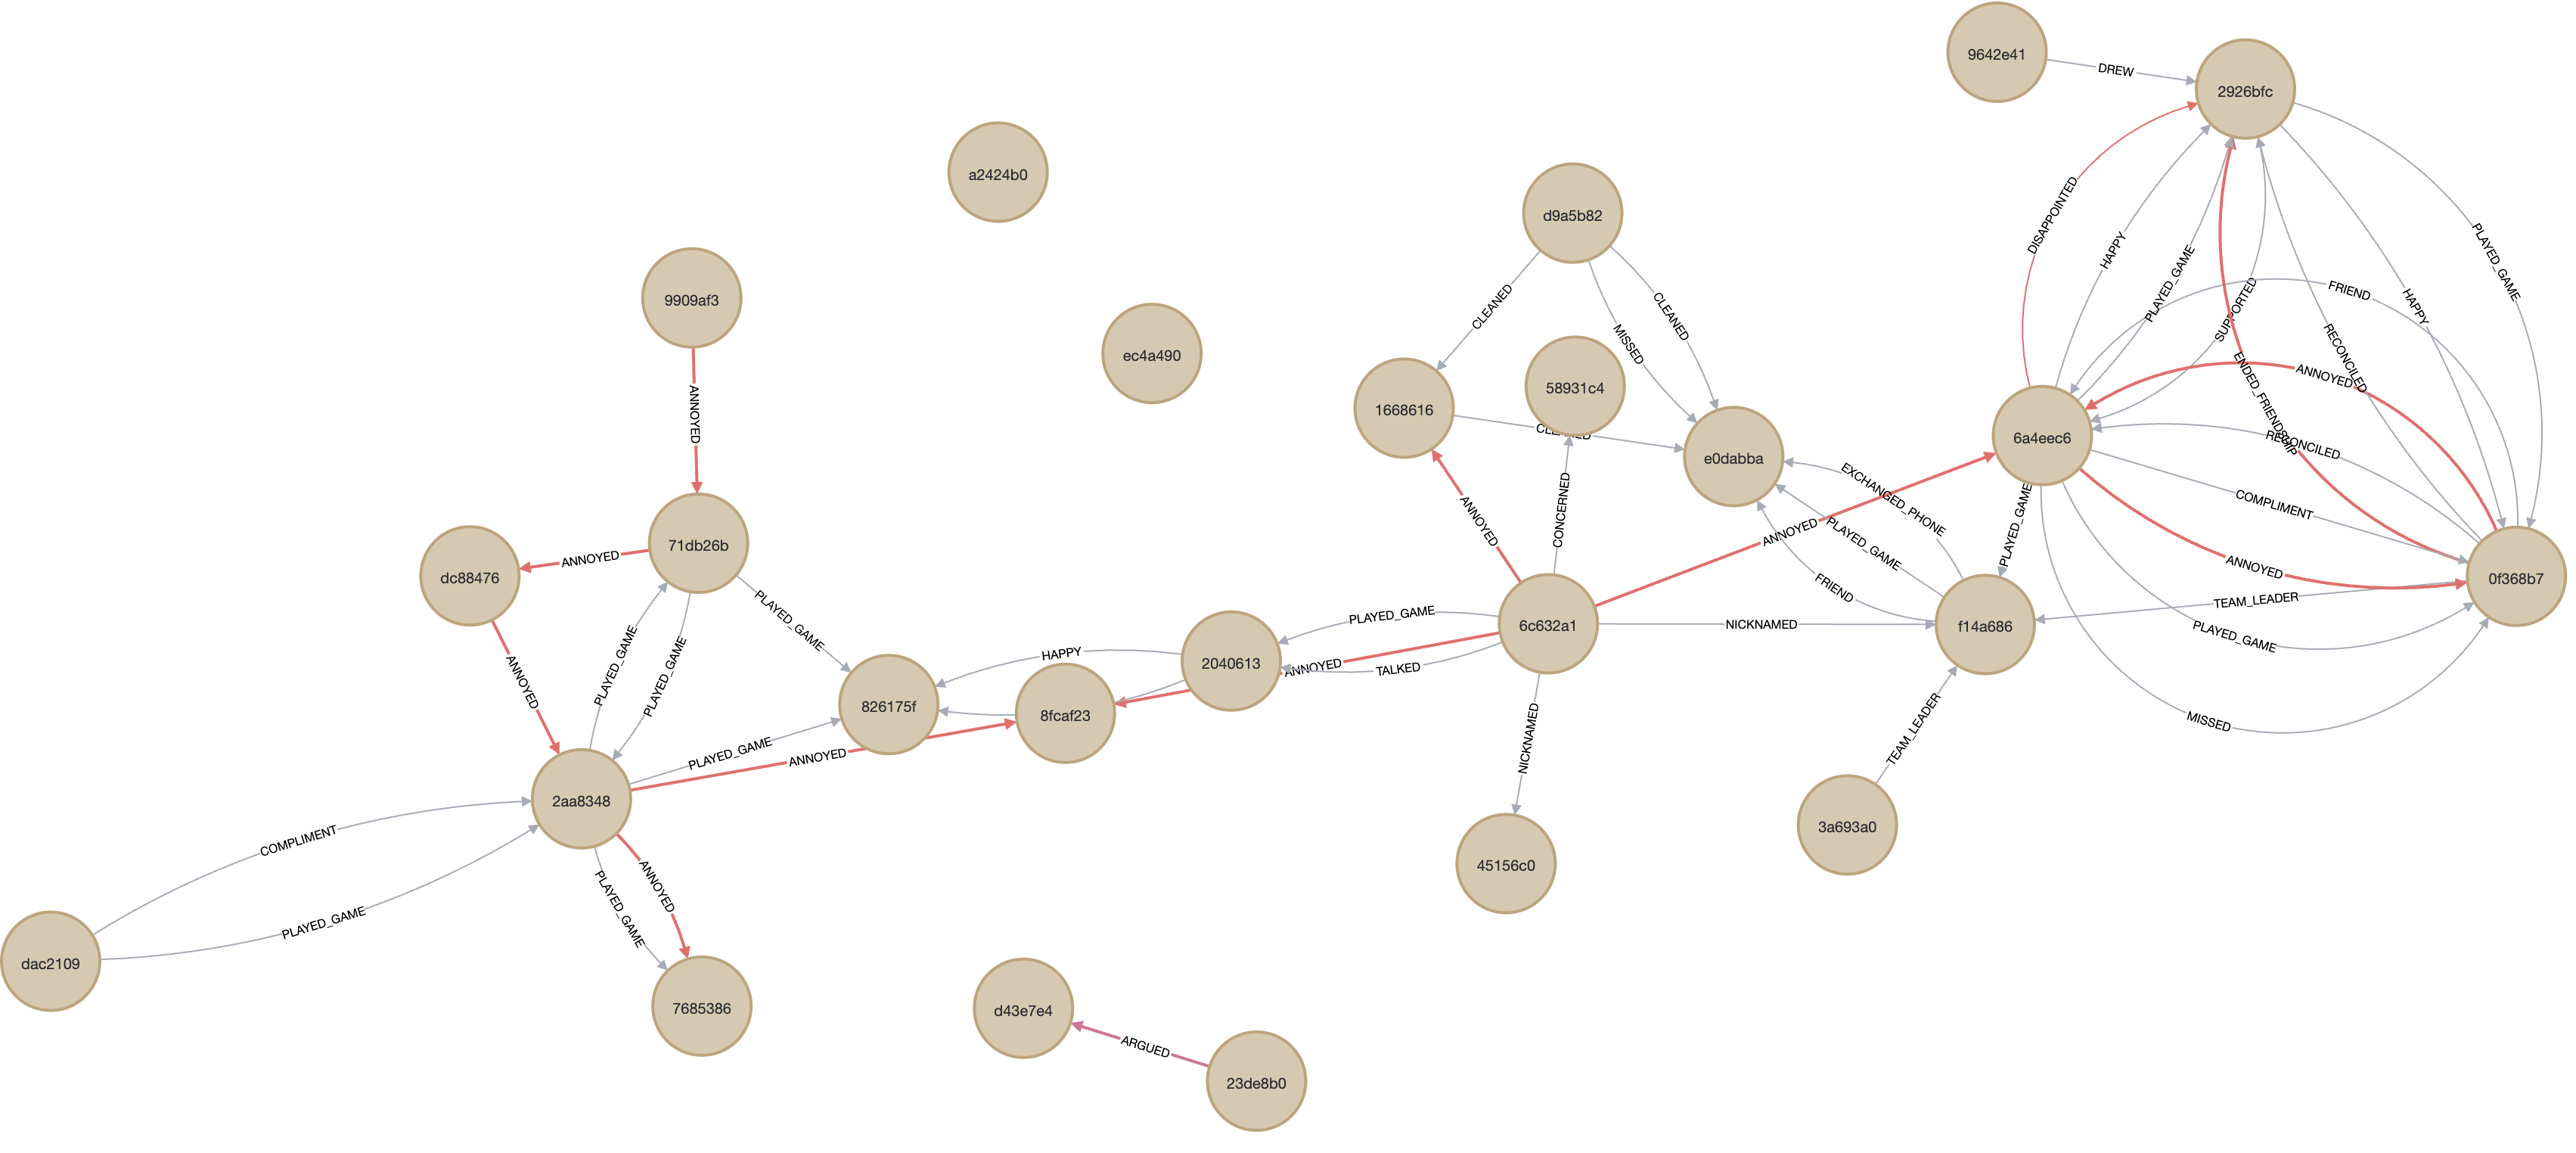

In [ ]:
# Result of Neo4j 

# This graph is drawn based on all students mentioned in the diary texts.

# ✅ Insight 1
# If student A’s diary describes the relationship between B and C,
# it reflects A’s perspective on B and C’s relationship and therefore may not be entirely objective.
# ✅ Insight 2
# "a2424b0" and "ec4a490" appear to have no social connections.  
# They can be considered socially isolated from their peer group, so I checked it.
# They did not refer to other students, and "a2424b0" explicitly stated that she had positive feelings toward all her friends.

display(Image(filename='assets/Neo4jgraph1.png'))

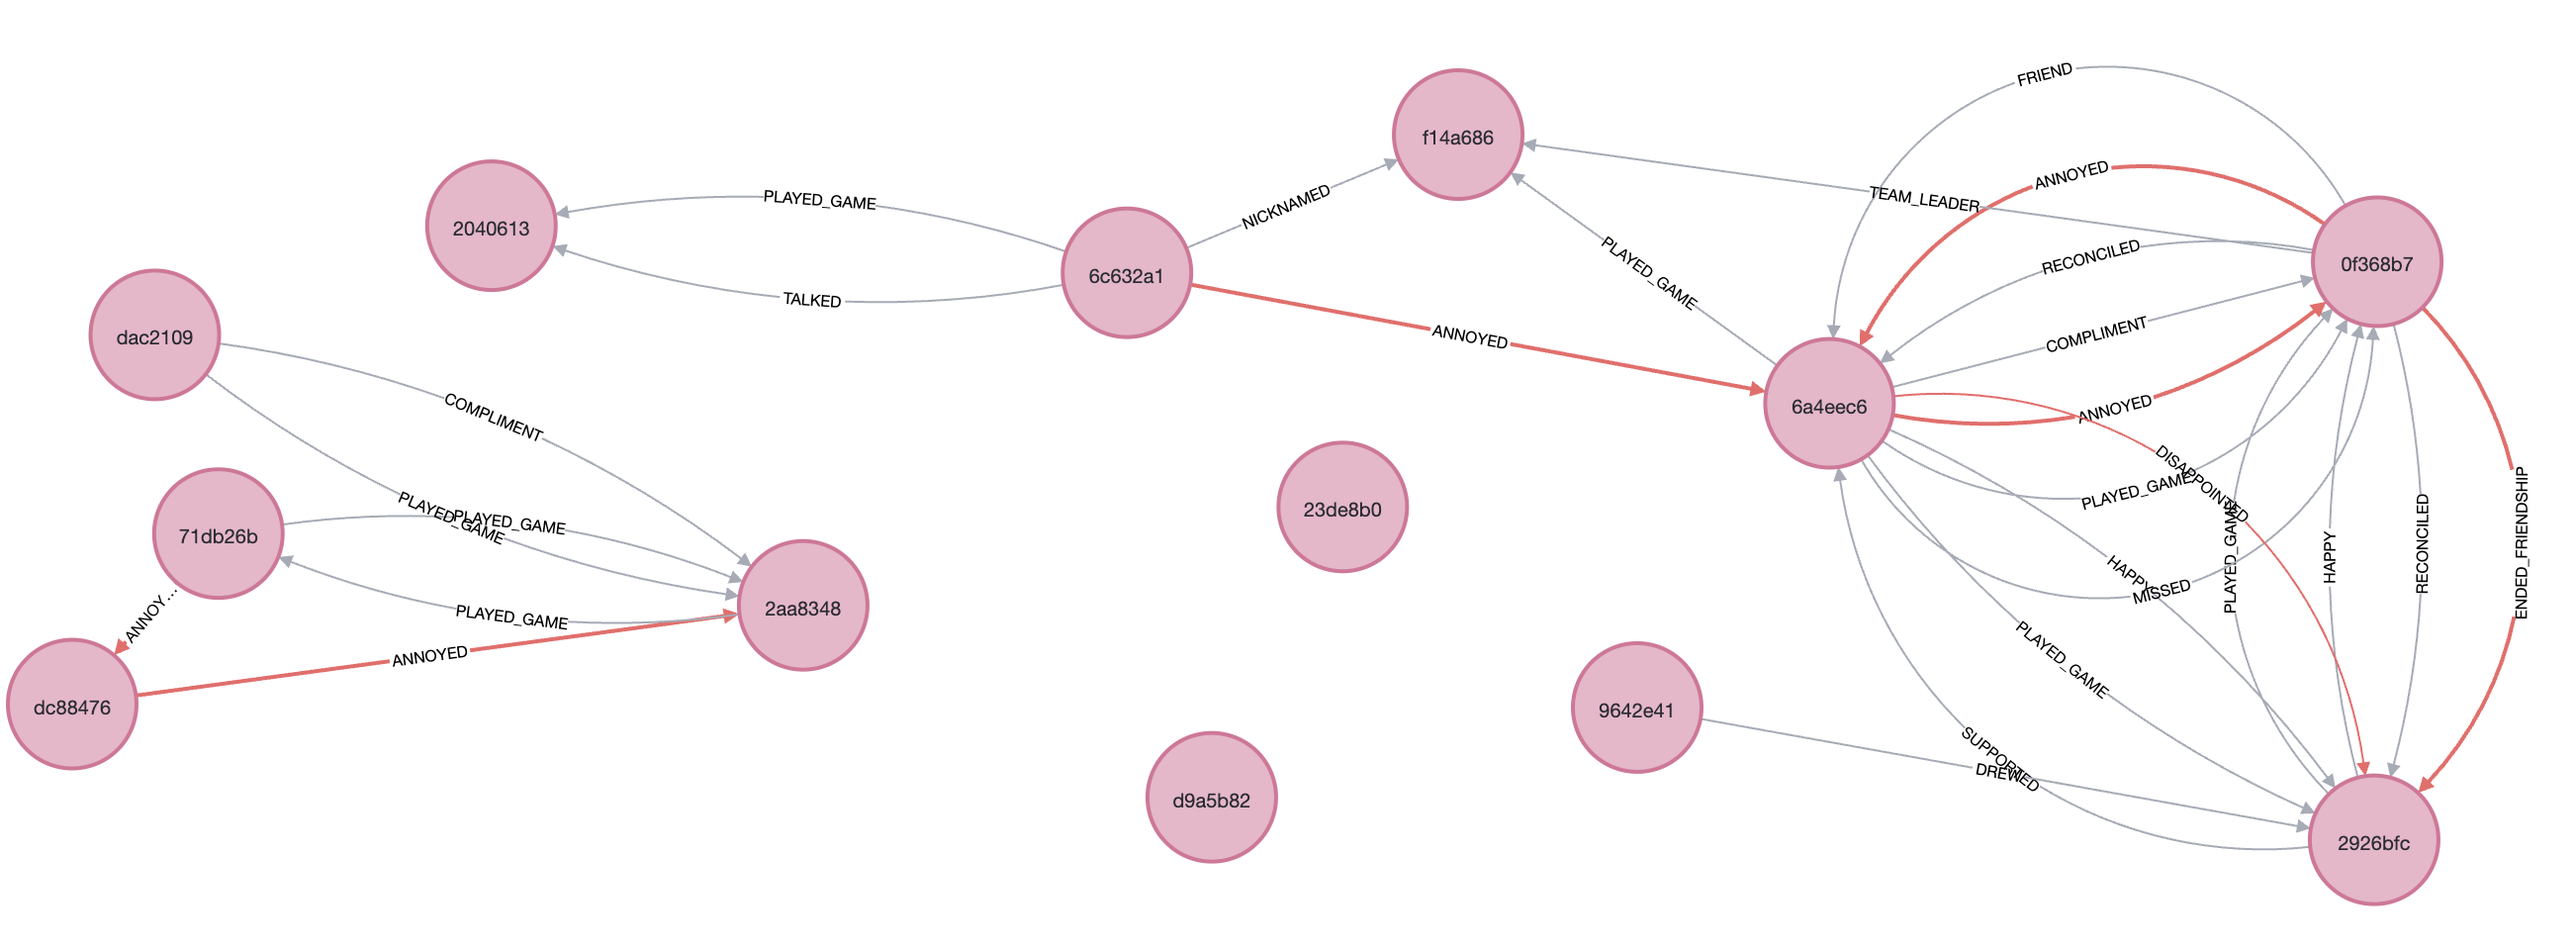

In [ ]:
# Draw a graph for students who mentioned other students' names in their diaries

# Result of Neo4j Cyper query 
"""
WHERE n.name IN [
'0f368b7', '71db26b', 'dac2109', 'dc88476', 'f14a686', '2aa8348',
'2040613', '6a4eec6', '23de8b0', '2926bfc', '9642e41', 'd9a5b82',
'6c632a1']
RETURN n"""

# ✅ Insight 1
# For example1 : '0f368b7', '2926bfc', '6a4eec6' students' focus heavily relies on each other, 
# showing that their relationship status can influence their emotions.
# Their feelings toward each other are diverse—not only happy or reconciled, 
# but also annoyed or ending friendships. This indicates that while they are close, 
# they also have frequent conflicts, which are sensitively observed.


display(Image(filename='assets/Neo4graph2.png'))

## Modeling

### Psedo-Labeling

In [19]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="sangrimlee/bert-base-multilingual-cased-nsmc", framework='pt')

# Manually correct the mislabeled data
# negative_words dictionary
negative_words = ["슬프", "아쉽", "아쉬", "화나다", "울고", "무섭", "긴장", "귀찮", "떨리다", "아프", "외롭"]
# positive_words dictionary
positive_words = ["상상", "궁금", "신난", "뿌듯", "흐뭇", "즐겁", "신기", "소망", "감사"]
nutural_words = ["그저", "그렇다"]

# Get the scores for each emotion words
def get_score_morphs(df, tag_colname):
    all_scores = []

    for i in range(len(df)):
        sentence = df[tag_colname][i]
        score = []
        # To get the scores for each emotion word, split the text using commas
        for part in sentence.split(","):
            part_clean = part.strip()
            result = classifier(part_clean)[0]
            # If the word is in the emotion dictionary(negative), treat it as negative.
            if any(neg_word in part_clean for neg_word in negative_words):
                adjusted_score = round(-abs(result['score']), 3)

            # If the word is in the emotion dictionary(negative), treat it as negative.
            elif any(pos_word in part_clean for pos_word in positive_words):
                adjusted_score = round(abs(result['score']), 3)
            else:
                # normal
                if result['label'].lower() == 'negative':
                    adjusted_score = round(-result['score'], 3)
                else:
                    adjusted_score = round(result['score'], 3)
            score.append(adjusted_score)
        all_scores.append(score)
    return all_scores

scores = get_score_morphs(diary, "Emotion")
scores[:10]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[[0.855, 0.963],
 [0.855, 0.963],
 [-0.652, -0.614],
 [0.973, 0.96, 0.855, 0.963, 0.844],
 [-0.599, -0.912],
 [0.977, 0.96, 0.963],
 [0.973, 0.96, 0.855, 0.963],
 [0.977, 0.96, 0.855, 0.963],
 [-0.599],
 [0.963]]

In [20]:
# labeling

diary_label = diary.copy()
def label_from_scores(all_scores):
    for i in range(len(all_scores)):
        all_positive = all(n > 0 for n in all_scores[i])
        all_negative = all(n < 0 for n in all_scores[i])

        # If all words are positive, label as 1
        if all_positive :
            label = 1
        # If all words are negative, label as 0
        elif all_negative :
            label = 0
        # If positive and negative are mixed, choose the one with the higher absolute value
        else :
            max_abs_num = max(all_scores[i], key = abs)
            lable =  1 if max_abs_num > 0 else 0

        diary_label.loc[i, 'label'] = label
    return diary_label

diary_label = label_from_scores(scores)


In [21]:
diary_label[11:15]

,Name,Number,Date,Weather,Emotion,Diary title,Diary,label
11,71db26b,일기 2,NaN,NaN,"즐겁다, 답답하다(다음에 또 하고 싶다)",오목,오늘은 오목을 했다. 2aa8348강 나랑 먼저 하고 다음은 826175f이랑 나랑...,1.0
12,71db26b,일기 3,2025-07-07,NaN,"속상하다, 화나다, 억울하다, 기분이 나쁘다, 화가 부글부글한다",생존수영,오늘은 생존수영을 배웠다. 근데 dc88476이가 벽에 안 붙어서 두 번 말했는데 ...,0.0
13,71db26b,일기 4,2025-07-08,NaN,"무섭다, 울고 싶다, 긴장하다",놀람,오늘은 새우등 뜨기랑 해파리 뜨기랑 페트병 들고 뜨기를 했는데 너무 무서워서 훌쩍이...,0.0
14,71db26b,일기 5,2025-07-09,NaN,"행복하다, 설레다, 재미있다",생존수영,"오늘은 구명조끼 배우기를 했다. 단계는 1, 2, 3, 4, 5, 6단계가 있었다....",1.0


### Sentiment Anaysis - BERT (Pretrained model VS Fine-tuned)

In [22]:
# Check the ratio
diary_label['label'].value_counts()

label
1.0    173
0.0     84
Name: count, dtype: int64

In [23]:
train_data = diary_label[['Diary', 'label']].sample(frac = 0.8, random_state = 42)
test_data = diary_label[['Diary', 'label']].drop(train_data.index)

In [24]:
# Pretrained model

# Load model
model_name = "beomi/KcELECTRA-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Create pipeline(text classification)
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Classification
results = []
for idx, row in test_data.iterrows() :
    result = classifier(row['Diary'])[0].get("label")
    results.append(result)

# # Correct the label format
test_data['prediction'] = results
test_data['pre_trained_label'] = test_data['prediction'].apply(lambda x : 0 if x == 'LABEL_0' else 1)
test_data.drop(['prediction'], axis = 1)

# Evaluation
y_true = test_data['label'] #real
y_pred = test_data['pre_trained_label'] #predict

acc = accuracy_score (y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Accuracy: {acc}, F1: {f1}, Precision: {precision}, Recall: {recall}")

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Accuracy: 0.43137254901960786, F1: 0.06451612903225806, Precision: 1.0, Recall: 0.03333333333333333


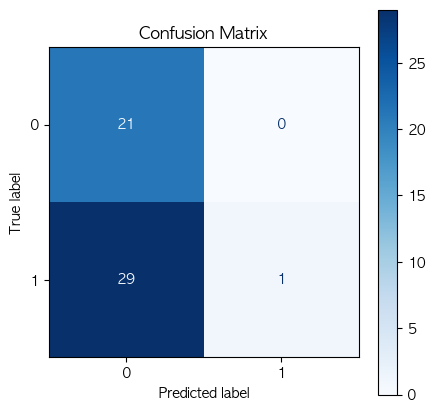

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Plot
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(cmap="Blues", ax=ax, values_format="d")
plt.title("Confusion Matrix")
plt.show()

In [26]:
# Fine tuning

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device :', device)

model_name = "beomi/KcELECTRA-base"

# Tokenising
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenized_train_sentences = tokenizer(
    list(train_data['Diary']),
    return_tensors = "pt",
    max_length = 128,
    padding = True,
    truncation = True,
    add_special_tokens = True)

tokenized_test_sentences = tokenizer(
    list(test_data['Diary']),
    return_tensors = "pt",
    max_length = 128,
    padding = True,
    truncation = True,
    add_special_tokens = True)

# Load Dataset
class CurseDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx], dtype=torch.long) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


    def __len__(self):
        return len(self.labels)

train_label= train_data["label"].values
test_label=test_data["label"].values

train_dataset = CurseDataset(tokenized_train_sentences, train_label)
test_dataset = CurseDataset(tokenized_test_sentences, test_label)

# Training
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2)
model.to(device)

training_args = TrainingArguments(
    output_dir = './',
    num_train_epochs= 3,
    per_device_train_batch_size= 16,
    per_device_eval_batch_size= 64,
    logging_dir = '.logs',
    logging_steps = 5,
    save_total_limit = 2,
    report_to=["none"]
)

# Evaluation
def compute_metrics(pred) :
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _  = precision_recall_fscore_support(labels, preds, average = 'binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy_score' : acc,
        'f1': f1,
        'precision' : precision,
        'recall' : recall
    }

# Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset=train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_metrics
)

device : cpu


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/39 [00:00<?, ?it/s]

{'loss': 0.6886, 'grad_norm': 32.792781829833984, 'learning_rate': 4.358974358974359e-05, 'epoch': 0.38}
{'loss': 0.592, 'grad_norm': 0.6523129343986511, 'learning_rate': 3.717948717948718e-05, 'epoch': 0.77}
{'loss': 0.5883, 'grad_norm': 0.9382327795028687, 'learning_rate': 3.0769230769230774e-05, 'epoch': 1.15}
{'loss': 0.6289, 'grad_norm': 0.9321914315223694, 'learning_rate': 2.435897435897436e-05, 'epoch': 1.54}
{'loss': 0.6205, 'grad_norm': 1.8845689296722412, 'learning_rate': 1.794871794871795e-05, 'epoch': 1.92}
{'loss': 0.5869, 'grad_norm': 1.0479899644851685, 'learning_rate': 1.153846153846154e-05, 'epoch': 2.31}
{'loss': 0.6145, 'grad_norm': 1.6838536262512207, 'learning_rate': 5.128205128205128e-06, 'epoch': 2.69}
{'train_runtime': 20.705, 'train_samples_per_second': 29.848, 'train_steps_per_second': 1.884, 'train_loss': 0.6112402341304681, 'epoch': 3.0}


TrainOutput(global_step=39, training_loss=0.6112402341304681, metrics={'train_runtime': 20.705, 'train_samples_per_second': 29.848, 'train_steps_per_second': 1.884, 'total_flos': 23818744953000.0, 'train_loss': 0.6112402341304681, 'epoch': 3.0})

In [28]:
trainer.evaluate(eval_dataset = test_dataset)

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6977468132972717,
 'eval_accuracy_score': 0.5882352941176471,
 'eval_f1': 0.7407407407407407,
 'eval_precision': 0.5882352941176471,
 'eval_recall': 1.0,
 'eval_runtime': 0.6514,
 'eval_samples_per_second': 78.292,
 'eval_steps_per_second': 1.535,
 'epoch': 3.0}

  0%|          | 0/1 [00:00<?, ?it/s]

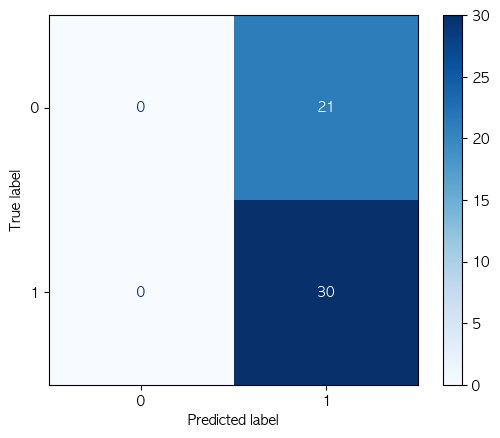

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 모델 예측
predictions = trainer.predict(test_dataset)

# 예측값과 정답 라벨 추출
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


## Generating products (Prompt engineering)
- using GPT-3.5-turbo

In [30]:
diary_LLM = diary_label.copy()

# Sentiment analysis and finding cause of the emotion

def analyze_emotion_and_cause(text):
    # 1. Sentiment analysis
    emotion_response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content":
             "Detect one or more emotions present in the input text and provide a score (e.g., from 0 to 1) indicating the intensity or confidence level for each detected emotion. "
             "Choose only from the following emotions: neutral, happy, joy, sadness, anger, worry. "
             "Example output format: {\"happy\": 0.8 , \"worry\": 0.6}"},
            {"role": "user", "content": text}
        ]
    )
    emotion_text = emotion_response.choices[0].message.content.strip()

    try:
        # Parsing with dictionary
        emotion_dict = json.loads(emotion_text)
    except:
        print("Emotion parsing error:", emotion_text)
        return {}, {}

    # 2. Finding cause of the emotion
    cause_prompt = f"""
    Given the following sentence and detected emotions, explain the cause for each emotion.
    Sentence: "{text}"
    Detected Emotions: {emotion_dict}

    Format your answer as a JSON dictionary mapping each emotion to its cause. Don't forget comma in JSON dictionary
    Example:

   {{"happy": "being able to play with Student14", "worry": "not being able to play with Student14"}}
    Answer in English only.
    """
    cause_response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": cause_prompt}
        ]
    )
    cause_text = cause_response.choices[0].message.content.strip()

    try:
        cause_dict = json.loads(cause_text)
    except:
        print("Cause parsing error:", cause_text)
        return emotion_dict, {}

    return emotion_dict, cause_dict

In [31]:
# Make 'emotion' and 'emotion_cause' columns in the dataframe
emotion_results = []
cause_results = []
#
for diary_text in diary_LLM['Diary']:
    try:
        emotion, cause = analyze_emotion_and_cause(diary_text)
    except Exception as e:
        emotion, cause = "error", str(e)

    emotion_results.append(emotion)
    cause_results.append(cause)

#
diary_LLM['emotion'] = emotion_results
diary_LLM['emotion_cause'] = cause_results

Cause parsing error: {
    "joy": "The cause of joy is receiving a score of 90 on a math problem in the math enrichment class that involved fractions and decimals. Although there was a feeling of regret for getting one answer wrong, overall there was a sense of satisfaction and enjoyment in solving the problems."
    "neutral": "The cause of feeling neutral could be the routine nature of the math class and the lack of strong emotions associated with the overall experience of doing fraction and decimal problems. It could also indicate a general acceptance of the situation without any strong positive or negative feelings."
}
Cause parsing error: {
    "joy": "The emotion of joy comes from the speaker participating in a survival swimming class, where they practiced floating in the water and playing games like 'shrimp back floating' and 'jellyfish floating'. The speaker found it fascinating to see a plastic bottle float in the water, and overall, they had a fun and enjoyable experience."
 

In [32]:
diary_LLM[11:15]

,Name,Number,Date,Weather,Emotion,Diary title,Diary,label,emotion,emotion_cause
11,71db26b,일기 2,NaN,NaN,"즐겁다, 답답하다(다음에 또 하고 싶다)",오목,오늘은 오목을 했다. 2aa8348강 나랑 먼저 하고 다음은 826175f이랑 나랑...,1.0,{'neutral': 1.0},{'neutral': 'The cause for the neutral emotion...
12,71db26b,일기 3,2025-07-07,NaN,"속상하다, 화나다, 억울하다, 기분이 나쁘다, 화가 부글부글한다",생존수영,오늘은 생존수영을 배웠다. 근데 dc88476이가 벽에 안 붙어서 두 번 말했는데 ...,0.0,"{'anger': 0.9, 'sadness': 0.8}",{'anger': 'feeling frustrated with dc88476 not...
13,71db26b,일기 4,2025-07-08,NaN,"무섭다, 울고 싶다, 긴장하다",놀람,오늘은 새우등 뜨기랑 해파리 뜨기랑 페트병 들고 뜨기를 했는데 너무 무서워서 훌쩍이...,0.0,"{'worry': 0.9, 'fear': 0.8, 'sadness': 0.7, 'n...",{'worry': 'Feeling overwhelmed and scared duri...
14,71db26b,일기 5,2025-07-09,NaN,"행복하다, 설레다, 재미있다",생존수영,"오늘은 구명조끼 배우기를 했다. 단계는 1, 2, 3, 4, 5, 6단계가 있었다....",1.0,"{'neutral': 0.8, 'joy': 0.2}",{'neutral': 'Describing the process of learnin...


In [42]:
diary_LLM.to_csv("diary_LLM.csv")

In [33]:
diary_LLM2 = diary_LLM.copy()

# Ready for adding emotion scores

columns = ['neutral', 'happy', 'joy', 'sadness', 'anger', 'worry']
zero = pd.DataFrame(0, index=range(257), columns=columns)

diary_LLM2 = pd.concat([diary_LLM2, zero],  axis = 1)


# Fill in the value if the corresponding key exists in the emotion dictionary for each emotion.
emotion_keys = ['happy', 'worry', 'joy', 'sadness', 'anger', 'neutral']

for key in emotion_keys:
    diary_LLM2[key] = diary_LLM2.apply(lambda row: row['emotion'].get(key) if pd.notnull(row['emotion']) and isinstance(row['emotion'], dict) else None, axis=1)

# Fillna
diary_LLM2[['happy', 'worry', 'joy', 'sadness', 'anger', 'neutral']] = \
    diary_LLM2[['happy', 'worry', 'joy', 'sadness', 'anger', 'neutral']].fillna(0)

In [34]:
diary_LLM2[11:15]

,Name,Number,Date,Weather,Emotion,Diary title,Diary,label,emotion,emotion_cause,neutral,happy,joy,sadness,anger,worry
11,71db26b,일기 2,NaN,NaN,"즐겁다, 답답하다(다음에 또 하고 싶다)",오목,오늘은 오목을 했다. 2aa8348강 나랑 먼저 하고 다음은 826175f이랑 나랑...,1.0,{'neutral': 1.0},{'neutral': 'The cause for the neutral emotion...,1.0,0.0,0.0,0.0,0.0,0.0
12,71db26b,일기 3,2025-07-07,NaN,"속상하다, 화나다, 억울하다, 기분이 나쁘다, 화가 부글부글한다",생존수영,오늘은 생존수영을 배웠다. 근데 dc88476이가 벽에 안 붙어서 두 번 말했는데 ...,0.0,"{'anger': 0.9, 'sadness': 0.8}",{'anger': 'feeling frustrated with dc88476 not...,0.0,0.0,0.0,0.8,0.9,0.0
13,71db26b,일기 4,2025-07-08,NaN,"무섭다, 울고 싶다, 긴장하다",놀람,오늘은 새우등 뜨기랑 해파리 뜨기랑 페트병 들고 뜨기를 했는데 너무 무서워서 훌쩍이...,0.0,"{'worry': 0.9, 'fear': 0.8, 'sadness': 0.7, 'n...",{'worry': 'Feeling overwhelmed and scared duri...,0.3,0.0,0.0,0.7,0.0,0.9
14,71db26b,일기 5,2025-07-09,NaN,"행복하다, 설레다, 재미있다",생존수영,"오늘은 구명조끼 배우기를 했다. 단계는 1, 2, 3, 4, 5, 6단계가 있었다....",1.0,"{'neutral': 0.8, 'joy': 0.2}",{'neutral': 'Describing the process of learnin...,0.8,0.0,0.2,0.0,0.0,0.0


In [35]:
diary_LLM2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           257 non-null    object 
 1   Number         257 non-null    object 
 2   Date           208 non-null    object 
 3   Weather        0 non-null      float64
 4   Emotion        257 non-null    object 
 5   Diary title    159 non-null    object 
 6   Diary          257 non-null    object 
 7   label          257 non-null    float64
 8   emotion        257 non-null    object 
 9   emotion_cause  257 non-null    object 
 10  neutral        257 non-null    float64
 11  happy          257 non-null    float64
 12  joy            257 non-null    float64
 13  sadness        257 non-null    float64
 14  anger          257 non-null    float64
 15  worry          257 non-null    float64
dtypes: float64(8), object(8)
memory usage: 32.3+ KB


In [ ]:
# Create dominant emotion dataframe → generate emotion calendar
diary_LLM3 = diary_LLM2.copy()
emotion_cols = ["neutral", "happy", "joy", "anger", "sadness", "worry"]

diary_LLM3["dominant_emotion"] = diary_LLM3[emotion_cols].idxmax(axis=1)  
diary_LLM3["dominant_score"] = diary_LLM3[emotion_cols].max(axis=1) 
diary_LLM3

,Name,Number,Date,Weather,Emotion,Diary title,Diary,label,emotion,emotion_cause,neutral,happy,joy,sadness,anger,worry,dominant_emotion,dominant_score
0,0f368b7,일기 1,2025-07-02,NaN,"기쁘다, 즐겁다",NaN,오늘은 6a4eec6랑 놀 수 있어서 너무 기쁘다. 그런데 못 놀 수도 있어서 좀 ...,1.0,"{'happy': 0.8, 'worry': 0.6}","{'happy': 'being able to play with sixa4eec6',...",0.0,0.8,0.0,0.0,0.0,0.6,happy,0.8
1,0f368b7,일기 2,2025-07-04,NaN,"기쁘다, 즐겁다",NaN,오늘은 비가 올 수가 있었서 밖에서 좀만 놀고 체육관으로 갈 거다. 그리고 6a4e...,1.0,"{'neutral': 1, 'joy': 0.8, 'worry': 0.3}",{'happy': 'The joy comes from the anticipation...,1.0,0.0,0.8,0.0,0.0,0.3,neutral,1.0
2,0f368b7,일기 3,NaN,NaN,"슬프다, 아쉽다",생존수영,생존수영을 할려고 했는데 배가 아파서 못했다. 그리고 생존수영 때문에 체육을 못했다.,0.0,"{'sadness': 0.9, 'worry': 0.7}",{'sadness': 'Unable to do survival swimming du...,0.0,0.0,0.0,0.9,0.0,0.7,sadness,0.9
3,0f368b7,일기 4,NaN,NaN,"좋아한다, 행복하다, 기쁘다, 즐겁다, 신기한다",NaN,생존영 오늘 처음 했는데 엄청 재미있었다. 내일도 해서 너무 기분이 좋다. 내일은 ...,1.0,"{'happy': 0.9, 'joy': 0.8}",{'happy': 'Having a great time and finding the...,0.0,0.9,0.8,0.0,0.0,0.0,happy,0.9
4,0f368b7,일기 5,2025-07-09,NaN,"화나다, 울고 싶다",NaN,내가 픽시를 많이 태워줬는데 6a4eec6 자기 거 픽시를 사는데 안 태워준다고 하...,0.0,"{'anger': 0.9, 'sadness': 0.7}",{'anger': 'Feeling frustrated because even tho...,0.0,0.0,0.0,0.7,0.9,0.0,anger,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,6c632a1,일기 8,2025-07-14,NaN,"역겹다, 걱정된다",NaN,오늘 체육시간에 피구를 하려 했는데 8fcaf23이 제 말투랑 몸짓을 취해서 싫었다...,0.0,"{'sadness': 0.8, 'anger': 0.7, 'worry': 0.9}",{'sadness': 'feeling disappointed that the spe...,0.0,0.0,0.0,0.8,0.7,0.9,worry,0.9
253,6c632a1,일기 9,2025-07-15,NaN,답답하다,NaN,오늘 아침에 학교에 늦었다. 원래는 8시 20~23분에 출발하는데 오늘은 8시 40...,0.0,"{'sadness': 0.8, 'worry': 0.7}",{'sadness': 'Being late for school and missing...,0.0,0.0,0.0,0.8,0.0,0.7,sadness,0.8
254,6c632a1,일기 10,2025-07-16,NaN,재미있다,NaN,오늘 급식시간에 무서운 얘기를 2040613이랑 하려 했는데 선생님이 얘들이 너무 ...,1.0,"{'joy': 0.7, 'worry': 0.4}",{'joy': 'being able to play with friends durin...,0.0,0.0,0.7,0.0,0.0,0.4,joy,0.7
255,6c632a1,일기 11,2025-07-17,NaN,"신기하다, 무섭다",NaN,오늘은 과학시간에 과학쌤에게 꾸중을 들었다. 나도 아니고 우리반 전체가 말이다. 과...,1.0,"{'anger': 0.9, 'fear': 0.8}",{'anger': 'The cause of anger stems from being...,0.0,0.0,0.0,0.0,0.9,0.0,anger,0.9


In [ ]:
# # Create dominant emotion dataframe 
# diary_LLM3 = diary_LLM2.copy()
# emotion_cols = ["neutral", "happy", "joy", "anger", "sadness", "worry"]

# diary_LLM3["dominant_emotion"] = diary_LLM3[emotion_cols].idxmax(axis=1)  
# diary_LLM3["dominant_score"] = diary_LLM3[emotion_cols].max(axis=1) 
# diary_LLM3[11:15]

,Name,Number,Date,Weather,Emotion,Diary_title,Diary,label,emotion,emotion_cause,neutral,happy,joy,sadness,anger,worry,dominant_emotion,dominant_score
11,753e216,일기 2,NaN,NaN,"즐겁다, 답답하다(다음에 또 하고 싶다)",오목,오늘은 오목을 했다. 8a2b9ef강 나랑 먼저 하고 다음은 91ab0aa이랑 나랑...,1.0,{'neutral': 1.0},"{'neutral': ""The speaker is describing a serie...",1.0,0.0,0.0,0.0,0.0,0.0,neutral,1.0
12,753e216,일기 3,2025-07-07,NaN,"속상하다, 화나다, 억울하다, 기분이 나쁘다, 화가 부글부글한다",생존수영,오늘은 생존수영을 배웠다. 근데 6ee5fe2이가 벽에 안 붙어서 두 번 말했는데 ...,0.0,"{'anger': 0.8, 'sadness': 0.7, 'worry': 0.4}","{'anger': ""Feeling frustrated because the pers...",0.0,0.0,0.0,0.7,0.8,0.4,anger,0.8
13,753e216,일기 4,2025-07-08,NaN,"무섭다, 울고 싶다, 긴장하다",놀람,오늘은 새우등 뜨기랑 해파리 뜨기랑 페트병 들고 뜨기를 했는데 너무 무서워서 훌쩍이...,0.0,"{'worry': 0.9, 'sadness': 0.7}",{'worry': 'The cause of worry in the sentence ...,0.0,0.0,0.0,0.7,0.0,0.9,worry,0.9
14,753e216,일기 5,2025-07-09,NaN,"행복하다, 설레다, 재미있다",생존수영,"오늘은 구명조끼 배우기를 했다. 단계는 1, 2, 3, 4, 5, 6단계가 있었다....",1.0,"{'neutral': 0.9, 'joy': 0.2, 'worry': 0.4}",{'neutral': 'Learning how to wear a life jacke...,0.9,0.0,0.2,0.0,0.0,0.4,neutral,0.9


In [37]:
diary_LLM3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              257 non-null    object 
 1   Number            257 non-null    object 
 2   Date              208 non-null    object 
 3   Weather           0 non-null      float64
 4   Emotion           257 non-null    object 
 5   Diary title       159 non-null    object 
 6   Diary             257 non-null    object 
 7   label             257 non-null    float64
 8   emotion           257 non-null    object 
 9   emotion_cause     257 non-null    object 
 10  neutral           257 non-null    float64
 11  happy             257 non-null    float64
 12  joy               257 non-null    float64
 13  sadness           257 non-null    float64
 14  anger             257 non-null    float64
 15  worry             257 non-null    float64
 16  dominant_emotion  257 non-null    object 
 1

In [38]:
# Drop rows with missing 'Date' → generate emotion graph
diary_LLM4 = diary_LLM3[diary_LLM3['Date'].notnull()]
diary_LLM4
diary_LLM4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 208 entries, 0 to 256
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              208 non-null    object 
 1   Number            208 non-null    object 
 2   Date              208 non-null    object 
 3   Weather           0 non-null      float64
 4   Emotion           208 non-null    object 
 5   Diary title       146 non-null    object 
 6   Diary             208 non-null    object 
 7   label             208 non-null    float64
 8   emotion           208 non-null    object 
 9   emotion_cause     208 non-null    object 
 10  neutral           208 non-null    float64
 11  happy             208 non-null    float64
 12  joy               208 non-null    float64
 13  sadness           208 non-null    float64
 14  anger             208 non-null    float64
 15  worry             208 non-null    float64
 16  dominant_emotion  208 non-null    object 
 17  do

## Emotion Calendar - Visualization(Streamlit)